In [4]:
from writers import foyer_xml_writer
from writers.foyer_xml_writer import parmed_to_foyer_xml, mbuild_to_foyer_xml
from bond_walk import MadAtom, MadBond, BondWalker


import ele
import espaloma as esp
import forcefield_utilities as ffutils
import foyer
import gmso
import mbuild as mb
from mbuild.lib.recipes import Polymer
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import numpy as np
from openff.toolkit.topology import Molecule
import torch
from mbuild.formats.hoomd_forcefield import create_hoomd_forcefield
import hoomd
import gsd.hoomd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore")

if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

Done!


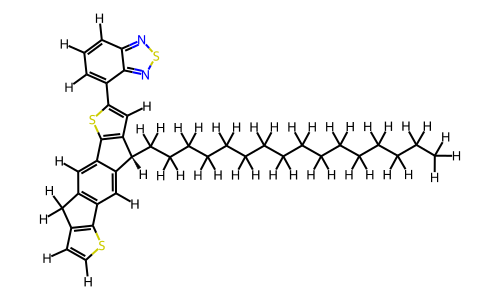

In [5]:
mol2_file = "/Users/madilyn/Projects/repos/forcefields/IDT_BT.mol2"
sdf_file = "/Users/madilyn/Projects/repos/forcefields/IDT_BT.sdf"


#using functions from bond_walker.py
b= BondWalker(Molecule.from_file(sdf_file,file_format = "sdf"))
compound = b.fill_in_bonds()
compound.visualize()

In [6]:



#Running the espaloma code

molecule = compound

molecule_graph = esp.Graph(molecule)

espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph)

# Store the results for each in something more accessible
pair_forces = openmm_system.getForces()[1]
angle_forces = openmm_system.getForces()[3]
bond_forces = openmm_system.getForces()[2]
torsion_forces = openmm_system.getForces()[0]


# get a parmed structure from openmm 
import parmed as pmd
topology = molecule.to_topology()
openmm_topology = topology.to_openmm()

structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
structure.bonds.sort(key=lambda x: x.atom1.idx)


for i in range(len(compound.atoms)):
    if compound.atoms[i].atomic_number == 6:
        compound.atoms[i].name = 'C'
    if compound.atoms[i].atomic_number == 1:
        compound.atoms[i].name = 'H'
    if compound.atoms[i].atomic_number == 7:
        compound.atoms[i].name = 'N'
    if compound.atoms[i].atomic_number == 16:
        compound.atoms[i].name = 'S'
    if compound.atoms[i].atomic_number == 8:
        compound.atoms[i].name = 'O'

import networkx  as nx
Gopenmm = nx.Graph()
Gparmed = nx.Graph()
#openmm:
for i in range(bond_forces.getNumBonds()):
    Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
#parmed
for b in structure.bonds:
    Gparmed.add_edge(b.atom1.idx,b.atom2.idx)
    
particle_types = []
type_map = dict()

#nx.rooted_tree_isomorphism
#in here we still need to check that one known index on one corresponds to the same index on the other....
tree_openmm = nx.bfs_tree(Gopenmm,0)
tree_parmed = nx.bfs_tree(Gparmed,0)
if nx.is_isomorphic(Gopenmm,Gparmed):
#if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
    for i in range(pair_forces.getNumParticles()):
        pair_parms = pair_forces.getParticleParameters(index=i)
        charge = pair_parms[0]
        sigma = pair_parms[1]
        epsilon = pair_parms[2]
        if (charge, sigma, epsilon) not in particle_types: 
            particle_types.append((charge, sigma, epsilon))
    
        type_map[compound.atoms[i].molecule_atom_index] = "".join([compound.atoms[i].name , str(particle_types.index((charge, sigma, epsilon)))])



# Rename the particle types so that they match the xml file
# This is needed when we aren't using SMARTS matching with Foyer.

mol2comp = mb.load(mol2_file)

for index in type_map:
    mol2comp[index].name = type_map[index]

#Create your dictionaries:

bond_types = []
bond_dict = dict() 

for i in range(bond_forces.getNumBonds()):
    bond_parms = bond_forces.getBondParameters(index=i)
    l0 = bond_parms[2]/bond_parms[2].unit
    k = bond_parms[3]/bond_parms[3].unit
    bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}
#print(bond_dict)



angle_types = []
angle_dict = dict()

for i in range(angle_forces.getNumAngles()):
    angle_parms = angle_forces.getAngleParameters(index=i)
    k = angle_parms[4]/angle_parms[4].unit
    t0 = angle_parms[3]/angle_parms[3].unit  
    angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}
#print(angle_dict)



dihedral_types = []
dihedral_dict = {}

for i in range(torsion_forces.getNumTorsions()):
    if i%6==0:
        periodicity=[]
        phase = []
        k = []
    dihedral_parms = torsion_forces.getTorsionParameters(index=i)
    periodicity.append(dihedral_parms[4])  
    phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
    k.append(dihedral_parms[6]/dihedral_parms[6].unit)
    dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                  type_map[dihedral_parms[3]])
   

    if periodicity[-1]==6:
        dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}
#print(dihedral_dict)




nonbonded_types = []
nonbonded_dict = {}

for i in range(pair_forces.getNumParticles()):
    nonbonded_parms = pair_forces.getParticleParameters(index=i)
    charge = nonbonded_parms[0]/nonbonded_parms[0].unit
    sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
    epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
    #if (charge,sigma,epsilon) not in nonbonded_types:
    nonbonded_types.append((charge,sigma,epsilon))
    nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}
#print(nonbonded_dict)

/Users/madilyn/miniconda3/envs/espaloma/bin/wrapped_progs/antechamber: Fatal Error!
Cannot properly run "/Users/madilyn/miniconda3/envs/espaloma/bin/sqm -O -i sqm.in -o sqm.out".


KeyboardInterrupt: 

In [ ]:
# Save the forcefield XML file for future use, so that we don't have to repeat the espaloma process everytime
mbuild_to_foyer_xml(
    file_name="CPDT.xml", #change this to whatever you want to save your xml file as
    compound=mol2comp,
    bond_params=bond_dict,
    angle_params=angle_dict,
    dihedral_params=dihedral_dict,
    dihedral_type="periodic",
    non_bonded_params=nonbonded_dict,
    combining_rule="geometric",
    name="",
    version="",
    coulomb14scale=1.0,
    lj14scale=1.0)

# Save the mb.Compound with the new atom type names for future use.
mol2comp.save("/Users/madilyn/Projects/repos/forcefields/CPDT_typed.mol2", overwrite=True) #change this to match your molecule name. 